In [10]:
import snap
from operator import itemgetter
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from random import choice
from pandas import datetools
import datetime
import numpy as np

### Loading the data

In [11]:
#G = nx.read_edgelist("data/vent.edgelist")
G = nx.read_edgelist("data/edges.csv", delimiter=',', create_using=nx.DiGraph)
metadata = pd.read_csv('data/metadata_merged.csv')

### Data preprocessing

In [12]:
metadata['Timestamp']= pd.to_datetime(metadata['created_at'])
del metadata['created_at']

In [13]:
metadata.head()

,emotion_id,user_id,reactions,emotion_category_id,emotion_name,enabled,category_name,Timestamp
0,134,1,0,15,Sad,True,Sadness,2013-12-17 13:29:06
1,134,2,17,15,Sad,True,Sadness,2014-01-01 08:44:40
2,134,2,0,15,Sad,True,Sadness,2014-01-07 03:51:00
3,134,2,0,15,Sad,True,Sadness,2014-02-07 05:18:38
4,134,2,0,15,Sad,True,Sadness,2014-02-11 13:43:09


# Activity stats per user (number of vents, first vent and last vent)

In [14]:
user_vents = metadata.groupby('user_id')['Timestamp'].agg(['count','min','max'])
user_vents.columns = ['num_vents', 'first_vent', 'last_vent']
user_vents.head()

,num_vents,first_vent,last_vent
user_id,,,
1,1,2013-12-17 13:29:06,2013-12-17 13:29:06.000
2,278,2013-12-30 20:33:32,2018-10-13 08:16:08.193
3,403,2013-12-31 02:50:24,2016-06-14 12:28:40.572
4,2,2013-12-31 03:02:54,2013-12-31 03:05:03.000
5,6,2013-12-31 04:27:36,2014-08-07 15:38:30.000


### Sum reaction, mean reaction and max reaction per user

In [15]:
user_reactions = metadata.groupby('user_id')['reactions'].agg(['sum','mean','max'])
user_reactions.columns = ['sum_reactions', 'mean_reactions', 'max_reaction']
user_reactions.head()

,sum_reactions,mean_reactions,max_reaction
user_id,,,
1,0,0.000000,0
2,1702,6.122302,57
3,2758,6.843672,130
4,0,0.000000,0
5,0,0.000000,0


### Merge the last two sets

In [16]:
user_activity = pd.merge(user_vents, user_reactions, how='inner', on='user_id')
user_activity.index.astype(int)
user_activity.head()

,num_vents,first_vent,last_vent,sum_reactions,mean_reactions,max_reaction
user_id,,,,,,
1,1,2013-12-17 13:29:06,2013-12-17 13:29:06.000,0,0.000000,0
2,278,2013-12-30 20:33:32,2018-10-13 08:16:08.193,1702,6.122302,57
3,403,2013-12-31 02:50:24,2016-06-14 12:28:40.572,2758,6.843672,130
4,2,2013-12-31 03:02:54,2013-12-31 03:05:03.000,0,0.000000,0
5,6,2013-12-31 04:27:36,2014-08-07 15:38:30.000,0,0.000000,0


### Histogram of number of vents per user (normal and log-scale)

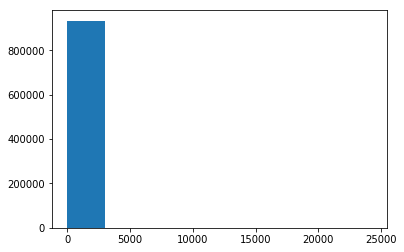

In [22]:
hist, bins, _ = plt.hist(user_activity['num_vents'], bins=8)

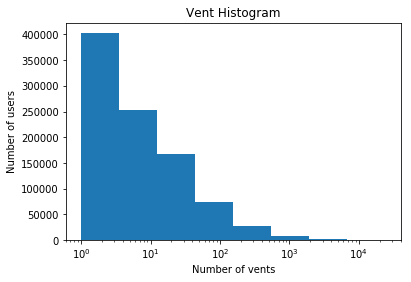

In [55]:
# histogram on log scale. 
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(user_activity['num_vents'], bins=logbins)
plt.xscale('log')
plt.title("Vent Histogram")
plt.xlabel("Number of vents")
plt.ylabel("Number of users")
plt.show()

# Network stats per node

In [21]:
nodes = G.nodes

In [22]:
node_and_degree = G.degree()

In [23]:
nodes_stats = pd.DataFrame([[i[0],i[1]] for i in dict(node_and_degree).items()], columns=['user_id', 'degree'])
nodes_stats.head()

,user_id,degree
0,287144,4
1,378467,13
2,378464,2
3,378465,69
4,287140,27


In [12]:
### eigenvector = nx.eigenvector_centrality(G)

In [13]:
#betweenness = nx.betweenness_centrality(G)

In [14]:
#nodes_stats.index = nodes_stats['user_id']
#del nodes_stats['user_id']
#nodes_stats.head()

In [24]:
user_activity.index=user_activity.index.astype(int)

In [25]:
nodes_stats['user_id']=nodes_stats['user_id'].astype(int)

### Adds to the activity user dataset a column witht the degrees

In [26]:
users_stats = pd.merge(nodes_stats, user_activity, how='inner', on='user_id')
users_stats.head()

,user_id,degree,num_vents,first_vent,last_vent,sum_reactions,mean_reactions,max_reaction
0,287144,4,1,2015-07-01 05:01:36.739,2015-07-01 05:01:36.739,1,1.000000,1
1,378467,13,4,2015-12-18 14:38:36.731,2015-12-22 22:17:55.232,17,4.250000,6
2,378464,2,5,2015-12-18 14:35:59.764,2015-12-22 05:56:45.742,23,4.600000,8
3,378465,69,124,2015-12-18 14:36:52.884,2017-04-15 14:43:27.586,933,7.524194,37
4,287140,27,2,2015-07-01 04:57:40.385,2015-07-02 11:02:17.449,11,5.500000,7


### Keeps users with degree more than 10 and less than 10000, that vents more than avereage (36)

In [27]:
user_filtered = users_stats[(users_stats['num_vents']>36) &
                            (users_stats['degree']<=10000) &
                            (users_stats['degree']>=10) 
                           ]
user_filtered['user_id']=user_filtered.index
user_filtered.head()

/Users/julian/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,user_id,degree,num_vents,first_vent,last_vent,sum_reactions,mean_reactions,max_reaction
3,3,69,124,2015-12-18 14:36:52.884,2017-04-15 14:43:27.586,933,7.524194,37
14,14,31,108,2015-03-31 08:00:37.000,2018-01-09 20:19:30.118,504,4.666667,24
21,21,86,88,2017-12-23 13:15:16.088,2018-03-09 00:36:17.254,1649,18.738636,1183
26,26,10,67,2017-12-23 13:32:43.061,2018-07-05 13:27:33.170,436,6.507463,20
37,37,75,1392,2015-12-15 03:32:33.197,2016-08-23 00:02:44.760,3871,2.780891,15


### Filters the metadata upon the filtered user list

In [29]:
metadata_filtered = metadata[metadata['user_id'].isin(user_filtered['user_id'])]

In [30]:
metadata_filtered.to_csv('data/metadata_filtered.csv', ' ')

### Creating a graph with the selected nodes

In [31]:
#edges_pd = nx.to_pandas_edgelist(G,'0','1')
edges_pd = pd.read_csv('data/edges.csv',',', index_col=False, comment='#')

In [32]:
edges_filtered = edges_pd[edges_pd['0'].isin(list(metadata_filtered['user_id']))]
edges_filtered = edges_filtered[edges_filtered['1'].isin(metadata_filtered['user_id'])]

In [41]:
edges_filtered.to_csv('data/edges_filtered.csv',',')

In [42]:
edges_filtered.count()

0    151974
1    151974
dtype: int64